# BPSK Demodulator Single Run

Operation of the BPSK Demodulator as a single run. See other Jupyter Notebook for performance testing (BER Curves). This Notebook contains many more plots which demonstrate what the reciever is doing at each step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import commpy
from dataclasses import dataclass
from scipy.special import erfc

from receiver import mandm, costas_loop, FIR
from waveform_gen import gen_waveform

In [2]:
# Simulation Directives
PLOT = True
TRANSMIT_IMAGE = True

# Simulation Parameters
num_symbols = 60000
L_tx = 16 # oversampling rate for adding offset impairment
L_rx = 4 # Data rate of receiver is 4 MSa/s
L_mm = 1
bitrate = int(1e6)
clock_drift_ppm = 30
RF_freq = 2e9
amp = 1 # Waveform amplitude
EbN0_dB = 4

if TRANSMIT_IMAGE:
    from data import data
    num_symbols = len(data)
    bits = np.array(data)
else:
    bits = np.random.binomial(1, 1/2, num_symbols)

# Encode Data
bits_encoded = 2*bits - 1 # NRZ-L

# Derived Parameters
tx_nsamp = num_symbols*L_tx
rx_nsamp = num_symbols*L_rx
Fs = L_tx*bitrate
EbN0_lin = 10**(EbN0_dB/10)
N0 = 1/EbN0_lin*L_tx
clock_drift = clock_drift_ppm*1e-6*RF_freq

# Generate BPSK Transmitted Samples

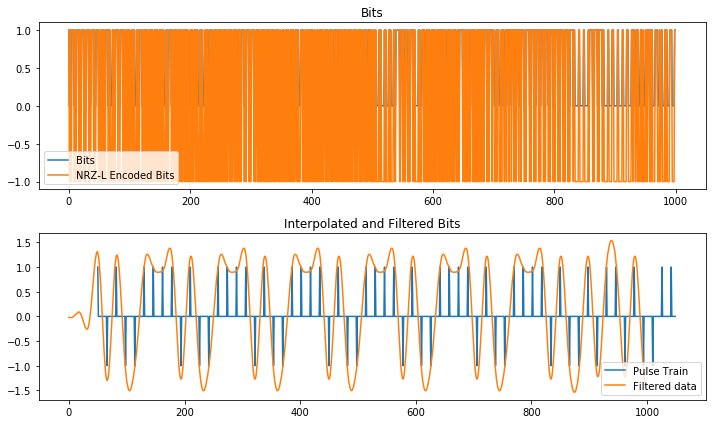

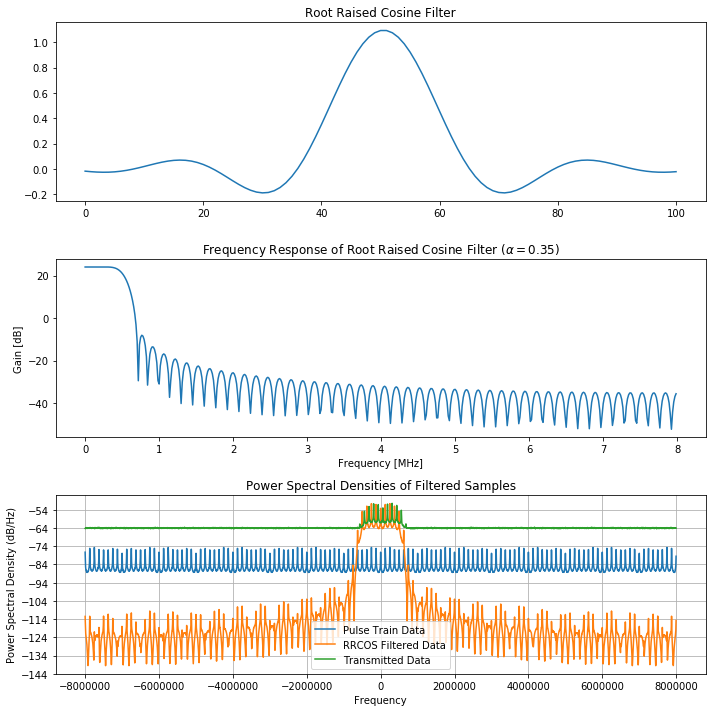

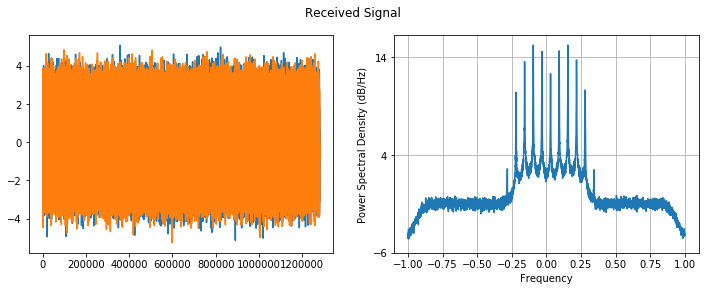

In [3]:
# Generate Data
bits_encoded = 2*bits - 1 # NRZ-L
bits_pulse_train = np.concatenate((bits_encoded.reshape((num_symbols, 1)), np.zeros((num_symbols, L_tx-1))), axis = 1).ravel()

# Apply Root Raised Cosine Filter
alpha = 0.35
num_taps_rrcos = 101
_, rrcos_taps = commpy.filters.rrcosfilter(num_taps_rrcos, alpha = 0.35, Ts = 1/bitrate, Fs = Fs)
bits_filt = np.convolve(bits_pulse_train, rrcos_taps)

# Impairments
bits_clk_offset = bits_filt * np.exp(2j*np.pi*np.arange(len(bits_filt))*clock_drift/Fs)
noise = np.sqrt(N0/2)*(np.random.randn(len(bits_clk_offset)) + 1j*np.random.randn(len(bits_clk_offset)))
bits_noisy = bits_clk_offset + noise
bits_noisy = np.pad(bits_noisy, (3, 400)) # Pad for FIR latency, timing error impairment
rx_samples = sig.resample_poly(bits_noisy, 1, L_tx/L_rx) # Decimate to 4Sa/Sym
num_rx_sa = len(rx_samples)

if PLOT:
    plt_max_idx = min(1000, len(bits))
    fig, ax = plt.subplots(2, 1, figsize = (10, 6))
    ax[0].set_title("Bits")
    ax[0].plot(bits[:plt_max_idx], label = "Bits")
    ax[0].plot(bits_encoded[:plt_max_idx], label = "NRZ-L Encoded Bits")
    ax[0].legend()
    ax[1].set_title("Interpolated and Filtered Bits")
    plt_max_idx = min(1000, tx_nsamp)
    ax[1].plot(np.arange(plt_max_idx) + num_taps_rrcos//2, bits_pulse_train[:plt_max_idx], label = "Pulse Train")
    ax[1].plot(bits_filt[:plt_max_idx], label = "Filtered data")
    ax[1].legend()
    fig.tight_layout()
    plt.show()
    
    f, h = sig.freqz(rrcos_taps, fs = Fs)
    fig, ax = plt.subplots(3, 1, figsize = (10, 10))
    ax[0].set_title("Root Raised Cosine Filter")
    ax[0].plot(rrcos_taps)
    ax[1].set_title(r"Frequency Response of Root Raised Cosine Filter ($\alpha = 0.35$)")
    ax[1].plot(f/1e6, 20*np.log10(np.abs(h)))
    ax[1].set_ylabel("Gain [dB]")
    ax[1].set_xlabel("Frequency [MHz]")
    ax[2].set_title("Power Spectral Densities of Filtered Samples")
    ax[2].psd(bits_pulse_train, 5000, Fs = Fs, sides = "twosided", label = "Pulse Train Data")
    ax[2].psd(bits_filt, 5000, Fs = Fs, sides = "twosided", label = "RRCOS Filtered Data")
    ax[2].psd(bits_noisy, 5000, Fs = Fs, label = "Transmitted Data")
    ax[2].legend()
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    fig.suptitle("Received Signal")
    ax[0].plot(rx_samples.real)
    ax[0].plot(rx_samples.imag)
    ax[1].psd(rx_samples, 5000)
    plt.show()

# BPSK Receiver

In [4]:
# Generate Taps for Root-Raised Cosine Filter
_, rrcos_taps = commpy.filters.rrcosfilter(num_taps_rrcos, alpha = 0.35, Ts = 1/bitrate, Fs = bitrate*L_rx)
rrcos_taps /= L_rx

# Instantiate Receiver Objects
fir_rrcos = FIR(rrcos_taps)
L_mm_interp = 16
Ltaps = sig.firwin2(6*L_mm_interp, [0, 1/L_mm_interp, 1/L_mm_interp + .01, 1], [1, 1, 0, 0])*L_mm_interp
MM = mandm(mu_gain = 0.008, iL = L_rx, L = L_mm_interp, Ltaps = Ltaps)
cl = costas_loop(alpha = .04, beta = 0.00132)

# Process Data Through Receiver Objects
for i, x in enumerate(rx_samples):
    filtered = fir_rrcos.update(x)
    time_recovered = MM.update(filtered)
    if time_recovered is not None:
        cl.update(time_recovered)

# Collect Logs from simulation
phases = np.array(cl.log_vco_phase)
vcos = np.array(cl.log_vco_out)
freqs = np.array(cl.log_vco_freq)/2/np.pi*bitrate
errors = np.array(cl.log_error)
outs = np.array(cl.log_out)
out_bits = ((np.sign(outs) + 1)/2).real.astype(int)
in_rate_mu = np.array(MM.log_in_rate_mu)
interp_rate_mu = np.array(MM.log_interp_rate_mu)
index = np.array(MM.log_idx)

In [5]:
bits_epad = np.pad(bits_encoded, (0, len(outs) - len(bits_encoded)))
corr = np.fft.ifft(np.fft.fft(bits_epad).conj()*np.fft.fft(outs))
shift = np.argmax(corr**2)
if corr[shift] < 0:
    # Invert if necessary
    out_bits = 1 - out_bits

aligned = out_bits[shift:]
converged_idx = np.sum(np.abs(freqs - clock_drift) > bitrate/1500)+1000

## Results

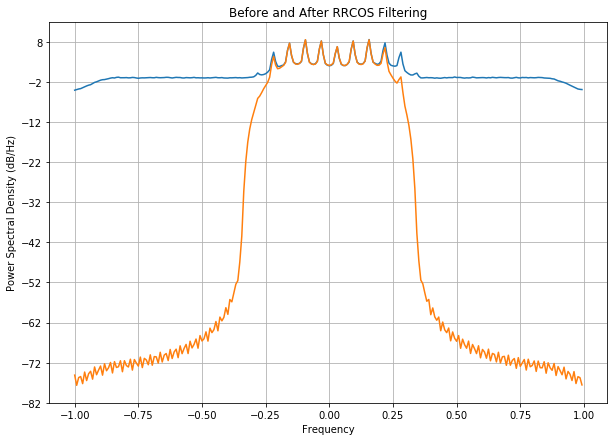

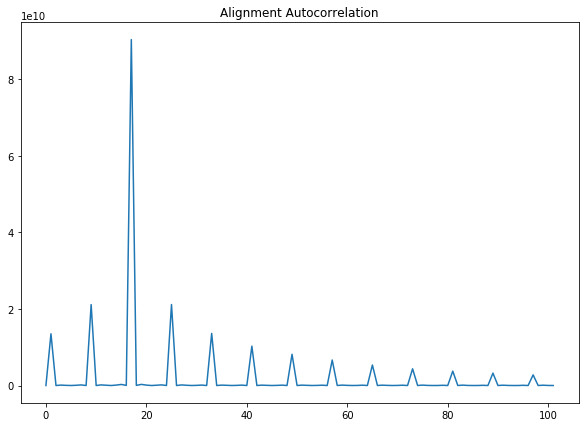

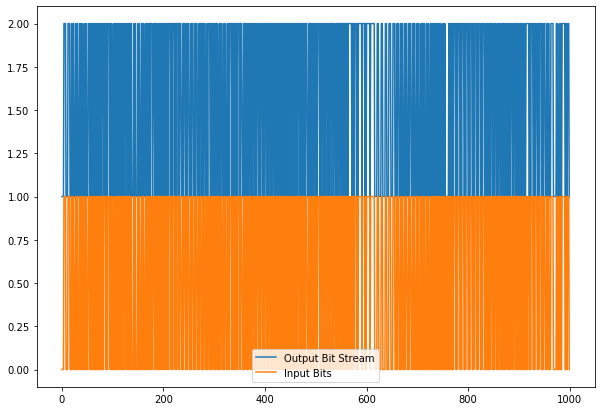

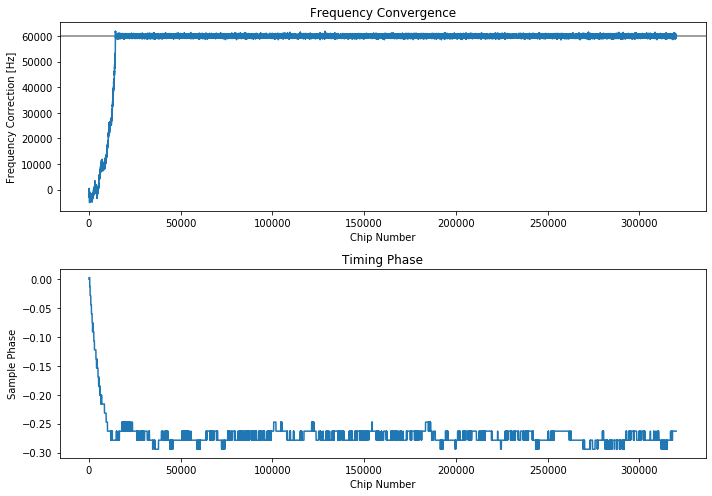

In [6]:
if PLOT:
    plt.figure(figsize = (10, 7))
    plt.title("Before and After RRCOS Filtering")
    plt.psd(rx_samples)
    plt.psd(fir_rrcos.data_out)
    plt.show()

    plt.figure(figsize = (10, 7))
    plt.title("Alignment Autocorrelation")
    plt.plot(np.abs(corr[:shift*6]**2))
    plt.show()

    plt.figure(figsize = (10, 7))
    max_plt_idx = min(1000, len(aligned) - converged_idx)
    plt.plot(aligned[converged_idx:converged_idx + max_plt_idx]+1, label = "Output Bit Stream")
    plt.plot(bits[converged_idx:converged_idx + max_plt_idx], label = "Input Bits")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots(2,1, figsize = (10, 7))
    ax[0].set_title("Frequency Convergence")
    ax[0].axhline(clock_drift, c = "k", alpha = .5)
    ax[0].plot(freqs)
    ax[0].set_xlabel("Chip Number")
    ax[0].set_ylabel("Frequency Correction [Hz]")
    ax[1].plot(np.unwrap(index%64)/64)
    ax[1].set_title("Timing Phase")
    ax[1].set_xlabel("Chip Number")
    ax[1].set_ylabel("Sample Phase")
    fig.tight_layout()
    plt.show()

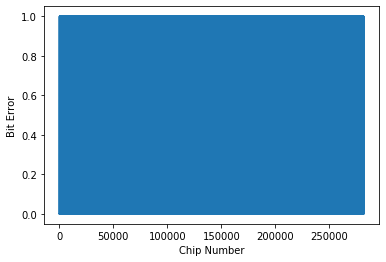

Performance: 0.013641625064799495
Theory: 0.01250081804073755


In [7]:
converged_aligned = aligned[converged_idx:len(bits)]
converged_bits = bits[converged_idx:]
errors = converged_aligned ^ converged_bits
error_rate = np.sum(errors)
plt.figure()
plt.plot(errors)
plt.xlabel("Chip Number")
plt.ylabel("Bit Error")
plt.show()

print(f"Performance: {error_rate/len(converged_aligned)}")
print(f"Theory: {0.5*erfc(np.sqrt(EbN0_lin))}")


## Image

Last, but not least, where we successfully able to recover our image?

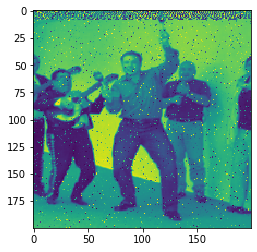

In [8]:
if TRANSMIT_IMAGE:
    conv = 2**np.arange(8)
    conv = conv[::-1]
    sz = 200
    image = np.zeros((sz, sz))
    for i in range(sz):
        for j in range(sz):
            idx = i*sz + j
            image[i][j] = np.dot(conv, aligned[8*idx:8*(idx+1)])

    plt.figure()
    plt.imshow(image)
    plt.show()